In [1]:
import logging
import os
import sys
import math
sys.path.append('scripts')
sys.path.append('share')
sys.path.append('python')
from collections import namedtuple
import numpy as np
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').disabled = True
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from run_training import _build_model, _find_py_file

In [2]:
logging.basicConfig(level=1, format='[%(asctime)s %(levelname)s] %(message)s')
Option = namedtuple("MyStruct", "input model name folds batch_size epochs")
                    #structure learning_rate regularizer epochs")
args = Option(
    input='data/train.h5',
    model='share/reference_number.py',
    name='NumberNetworkKFOLD',
    folds=10,
    batch_size=60,
    epochs=20,
    #learning_rate=0.0001,
    #regularizer=0.0001,
)

path = _find_py_file(args.model)

# K-Fold Validation
## Load and Split Data

In [3]:
logging.info(f'Loading data from {args.input}')

with h5.File(args.input, 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

labels = ['1particle', '2particle', '3particle']

[2020-07-09 03:16:25,205 INFO] Loading data from data/train.h5


In [4]:
logging.info('Building model from %s', path)
model, compile_args, fit_args, params = _build_model(path, data_x, data_y)

[2020-07-09 03:16:34,200 INFO] Building model from share/reference_number.py


In [5]:
#model.summary()

In [6]:
#keras.utils.plot_model(model)

In [7]:
#FOR ITERATIVE TESTING QUICKER
#data_x = data_x[:5000]
#data_y = data_y[:5000]

In [8]:
models = []
#histories = []
#preds = []
#reals = []
fpr = {}
tpr = {}
auc1 = {}
acc_per_fold = []
loss_per_fold = []

# DATA COMES PRESHUFFLED NOW

#dont forget to shuffle
#data = np.concatenate([data_x, data_y], axis=1)
#rng = np.random.default_rng(seed=42)
#rng.shuffle(data)

#data_x = data[:, 0:data_x.shape[1]]
#data_y = data[:, data_x.shape[1]:data.shape[1]]

#K-Fold Split Indices
kfold = KFold(n_splits=args.folds)
splits = kfold.split(data_x,data_y)

#
# To Do: Barrel and Endcap Layer Seperation
# Index of data_x in axis=1 corresponds to
# IBL: array[56] ==0 && array[57]==0
# Barrel: array[56] >0 && array[57]==0
# Endcap: array[57]!=0
#

## Training and Validation

In [9]:
fold_no = 0
with h5.File(f'output/{args.name}.h5', 'w'):
    logging.info(f'output/{args.name}.h5 created/emptied')

for train, test in splits:
    fold_no += 1
    logging.info(f'Building model for fold {fold_no} from {path}...')
    model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
    compile_args['metrics']=['accuracy']
    fit_args['batch_size']=args.batch_size
    fit_args['validation_split'] = 0.1
    fit_args['epochs'] = args.epochs
    fit_args['callbacks'] = [keras.callbacks.TerminateOnNaN(),
                             keras.callbacks.ModelCheckpoint(args.name + str(fold_no) + '.h5', save_best_only=True,verbose=1)]
                             #keras.callbacks.CSVLogger('output/'+args.name+str(fold_no)+'.csv')]
    logging.info(f'Compiling for fold {fold_no} ...')
    model.compile(**compile_args)

    logging.info(f'Training for fold {fold_no} ...')
    history = model.fit(data_x[train], data_y[train], **fit_args)
    
    logging.info(f'Testing on fold {fold_no} ...')
    scores = model.evaluate(data_x[test], data_y[test])
    
    logging.info(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1] * 100}%')
    acc_per_fold.append(scores[1]*100)
    loss_per_fold.append(scores[0])
    
    logging.info(f'Calculating inference for fold {fold_no} ...')
    y_pred = model.predict(data_x[test])
    #preds.append(y_pred)
    #reals.append(data_y[test])
    
    for i, label in enumerate(labels):
        fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'], threshold = roc_curve(data_y[test][:,i], y_pred[:,i])
        auc1[f'{label}_{fold_no}'] = auc(fpr[f'{label}_{fold_no}'], tpr[f'{label}_{fold_no}'])
        
    logging.info(f'Writing fit history to output/{args.name}.h5')
    with h5.File(f'output/{args.name}.h5', 'a') as hfile:
        for key, val in history.history.items():
            hfile.create_dataset(key+'_'+str(fold_no), data=np.array(val))
        for label in labels:
            hfile.create_dataset(f'{label}_{fold_no}_fpr', data=fpr[f'{label}_{fold_no}'])
            hfile.create_dataset(f'{label}_{fold_no}_tpr', data=tpr[f'{label}_{fold_no}'])
            hfile.create_dataset(f'{label}_{fold_no}_auc', data=auc1[f'{label}_{fold_no}'])
    models.append(model)

logging.info('Done training!')


[2020-07-09 03:29:30,549 INFO] output/NumberNetworkKFOLD.h5 created/emptied
[2020-07-09 03:29:30,657 INFO] Building model for fold 1 from share/reference_number.py...
[2020-07-09 03:29:34,312 INFO] Compiling for fold 1 ...
[2020-07-09 03:29:34,325 INFO] Training for fold 1 ...


Epoch 1/20
197372/197417 [============================>.] - ETA: 0s - loss: 0.5419 - accuracy: 0.7597
Epoch 00001: val_loss improved from inf to 0.55265, saving model to NumberNetworkKFOLD1.h5
197417/197417 [==============================] - 153s 777us/step - loss: 0.5418 - accuracy: 0.7597 - val_loss: 0.5527 - val_accuracy: 0.7541
Epoch 2/20
197390/197417 [============================>.] - ETA: 0s - loss: 0.4938 - accuracy: 0.7866
Epoch 00002: val_loss improved from 0.55265 to 0.48407, saving model to NumberNetworkKFOLD1.h5
197417/197417 [==============================] - 157s 798us/step - loss: 0.4938 - accuracy: 0.7866 - val_loss: 0.4841 - val_accuracy: 0.7913
Epoch 3/20
197355/197417 [============================>.] - ETA: 0s - loss: 0.4839 - accuracy: 0.7923
Epoch 00003: val_loss improved from 0.48407 to 0.47611, saving model to NumberNetworkKFOLD1.h5
197417/197417 [==============================] - 156s 792us/step - loss: 0.4839 - accuracy: 0.7923 - val_loss: 0.4761 - val_accurac

[2020-07-09 04:20:21,619 INFO] Testing on fold 1 ...


45699/45699 [==============================] - 24s 520us/step - loss: 0.4572 - accuracy: 0.8056


[2020-07-09 04:20:45,658 INFO] Score for fold 1: loss of 0.45716723799705505; accuracy of 80.56027889251709%
[2020-07-09 04:20:45,659 INFO] Calculating inference for fold 1 ...
[2020-07-09 04:21:00,186 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 04:21:00,273 INFO] Building model for fold 2 from share/reference_number.py...
[2020-07-09 04:21:03,656 INFO] Compiling for fold 2 ...
[2020-07-09 04:21:03,663 INFO] Training for fold 2 ...


Epoch 1/20
197388/197417 [============================>.] - ETA: 0s - loss: 0.5400 - accuracy: 0.7605
Epoch 00001: val_loss improved from inf to 0.49244, saving model to NumberNetworkKFOLD2.h5
197417/197417 [==============================] - 149s 755us/step - loss: 0.5400 - accuracy: 0.7605 - val_loss: 0.4924 - val_accuracy: 0.7862
Epoch 2/20
197369/197417 [============================>.] - ETA: 0s - loss: 0.4873 - accuracy: 0.7895
Epoch 00002: val_loss improved from 0.49244 to 0.47939, saving model to NumberNetworkKFOLD2.h5
197417/197417 [==============================] - 149s 756us/step - loss: 0.4873 - accuracy: 0.7895 - val_loss: 0.4794 - val_accuracy: 0.7937
Epoch 3/20
197366/197417 [============================>.] - ETA: 0s - loss: 0.4786 - accuracy: 0.7943
Epoch 00003: val_loss improved from 0.47939 to 0.47083, saving model to NumberNetworkKFOLD2.h5
197417/197417 [==============================] - 149s 753us/step - loss: 0.4786 - accuracy: 0.7943 - val_loss: 0.4708 - val_accurac

[2020-07-09 05:10:49,557 INFO] Testing on fold 2 ...


45699/45699 [==============================] - 30s 664us/step - loss: 0.4595 - accuracy: 0.8050


[2020-07-09 05:11:20,203 INFO] Score for fold 2: loss of 0.4595009386539459; accuracy of 80.50221800804138%
[2020-07-09 05:11:20,204 INFO] Calculating inference for fold 2 ...
[2020-07-09 05:11:35,633 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 05:11:35,720 INFO] Building model for fold 3 from share/reference_number.py...
[2020-07-09 05:11:39,197 INFO] Compiling for fold 3 ...
[2020-07-09 05:11:39,205 INFO] Training for fold 3 ...


Epoch 1/20
197374/197417 [============================>.] - ETA: 0s - loss: 0.5384 - accuracy: 0.7614
Epoch 00001: val_loss improved from inf to 0.49049, saving model to NumberNetworkKFOLD3.h5
197417/197417 [==============================] - 161s 814us/step - loss: 0.5384 - accuracy: 0.7615 - val_loss: 0.4905 - val_accuracy: 0.7867
Epoch 2/20
197376/197417 [============================>.] - ETA: 0s - loss: 0.4896 - accuracy: 0.7882
Epoch 00002: val_loss improved from 0.49049 to 0.48002, saving model to NumberNetworkKFOLD3.h5
197417/197417 [==============================] - 160s 812us/step - loss: 0.4896 - accuracy: 0.7882 - val_loss: 0.4800 - val_accuracy: 0.7943
Epoch 3/20
197354/197417 [============================>.] - ETA: 0s - loss: 0.4809 - accuracy: 0.7929
Epoch 00003: val_loss improved from 0.48002 to 0.47614, saving model to NumberNetworkKFOLD3.h5
197417/197417 [==============================] - 158s 803us/step - loss: 0.4809 - accuracy: 0.7929 - val_loss: 0.4761 - val_accurac

[2020-07-09 06:01:45,483 INFO] Testing on fold 3 ...


45699/45699 [==============================] - 24s 528us/step - loss: 0.4637 - accuracy: 0.8036


[2020-07-09 06:02:09,845 INFO] Score for fold 3: loss of 0.4636576771736145; accuracy of 80.36224246025085%
[2020-07-09 06:02:09,845 INFO] Calculating inference for fold 3 ...
[2020-07-09 06:02:23,627 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 06:02:23,717 INFO] Building model for fold 4 from share/reference_number.py...
[2020-07-09 06:02:27,456 INFO] Compiling for fold 4 ...
[2020-07-09 06:02:27,462 INFO] Training for fold 4 ...


Epoch 1/20
197371/197417 [============================>.] - ETA: 0s - loss: 0.5418 - accuracy: 0.7601
Epoch 00001: val_loss improved from inf to 0.50759, saving model to NumberNetworkKFOLD4.h5
197417/197417 [==============================] - 150s 761us/step - loss: 0.5418 - accuracy: 0.7601 - val_loss: 0.5076 - val_accuracy: 0.7758
Epoch 2/20
197359/197417 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7875
Epoch 00002: val_loss improved from 0.50759 to 0.49833, saving model to NumberNetworkKFOLD4.h5
197417/197417 [==============================] - 147s 746us/step - loss: 0.4912 - accuracy: 0.7875 - val_loss: 0.4983 - val_accuracy: 0.7825
Epoch 3/20
197393/197417 [============================>.] - ETA: 0s - loss: 0.4819 - accuracy: 0.7926
Epoch 00003: val_loss improved from 0.49833 to 0.47466, saving model to NumberNetworkKFOLD4.h5
197417/197417 [==============================] - 147s 745us/step - loss: 0.4819 - accuracy: 0.7926 - val_loss: 0.4747 - val_accurac

[2020-07-09 06:51:48,497 INFO] Testing on fold 4 ...


45699/45699 [==============================] - 24s 530us/step - loss: 0.4593 - accuracy: 0.8048


[2020-07-09 06:52:13,104 INFO] Score for fold 4: loss of 0.4593290388584137; accuracy of 80.47602772712708%
[2020-07-09 06:52:13,105 INFO] Calculating inference for fold 4 ...
[2020-07-09 06:52:26,818 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 06:53:30,228 INFO] Building model for fold 5 from share/reference_number.py...
[2020-07-09 06:53:35,046 INFO] Compiling for fold 5 ...
[2020-07-09 06:53:35,053 INFO] Training for fold 5 ...


Epoch 1/20
197389/197417 [============================>.] - ETA: 0s - loss: 0.5376 - accuracy: 0.7623
Epoch 00001: val_loss improved from inf to 0.49117, saving model to NumberNetworkKFOLD5.h5
197417/197417 [==============================] - 151s 766us/step - loss: 0.5376 - accuracy: 0.7623 - val_loss: 0.4912 - val_accuracy: 0.7911
Epoch 2/20
197394/197417 [============================>.] - ETA: 0s - loss: 0.4915 - accuracy: 0.7879
Epoch 00002: val_loss improved from 0.49117 to 0.47728, saving model to NumberNetworkKFOLD5.h5
197417/197417 [==============================] - 148s 748us/step - loss: 0.4915 - accuracy: 0.7879 - val_loss: 0.4773 - val_accuracy: 0.7961
Epoch 3/20
197402/197417 [============================>.] - ETA: 0s - loss: 0.4818 - accuracy: 0.7928
Epoch 00003: val_loss did not improve from 0.47728
197417/197417 [==============================] - 148s 749us/step - loss: 0.4818 - accuracy: 0.7928 - val_loss: 0.4809 - val_accuracy: 0.7924
Epoch 4/20
197375/197417 [========

[2020-07-09 07:43:15,836 INFO] Testing on fold 5 ...


45699/45699 [==============================] - 24s 531us/step - loss: 0.4602 - accuracy: 0.8051


[2020-07-09 07:43:40,782 INFO] Score for fold 5: loss of 0.4601914882659912; accuracy of 80.50960302352905%
[2020-07-09 07:43:40,783 INFO] Calculating inference for fold 5 ...
[2020-07-09 07:43:56,189 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 07:44:05,067 INFO] Building model for fold 6 from share/reference_number.py...
[2020-07-09 07:44:12,642 INFO] Compiling for fold 6 ...
[2020-07-09 07:44:12,649 INFO] Training for fold 6 ...


Epoch 1/20
197404/197417 [============================>.] - ETA: 0s - loss: 0.5395 - accuracy: 0.7607
Epoch 00001: val_loss improved from inf to 0.52507, saving model to NumberNetworkKFOLD6.h5
197417/197417 [==============================] - 148s 752us/step - loss: 0.5395 - accuracy: 0.7607 - val_loss: 0.5251 - val_accuracy: 0.7706
Epoch 2/20
197389/197417 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7873
Epoch 00002: val_loss improved from 0.52507 to 0.49044, saving model to NumberNetworkKFOLD6.h5
197417/197417 [==============================] - 148s 751us/step - loss: 0.4912 - accuracy: 0.7873 - val_loss: 0.4904 - val_accuracy: 0.7888
Epoch 3/20
197406/197417 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.7924
Epoch 00003: val_loss improved from 0.49044 to 0.47464, saving model to NumberNetworkKFOLD6.h5
197417/197417 [==============================] - 149s 752us/step - loss: 0.4821 - accuracy: 0.7924 - val_loss: 0.4746 - val_accurac

[2020-07-09 08:33:53,507 INFO] Testing on fold 6 ...


45699/45699 [==============================] - 24s 526us/step - loss: 0.4581 - accuracy: 0.8053


[2020-07-09 08:34:17,768 INFO] Score for fold 6: loss of 0.4581122398376465; accuracy of 80.52593469619751%
[2020-07-09 08:34:17,769 INFO] Calculating inference for fold 6 ...
[2020-07-09 08:34:31,306 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 08:34:31,569 INFO] Building model for fold 7 from share/reference_number.py...
[2020-07-09 08:34:34,899 INFO] Compiling for fold 7 ...
[2020-07-09 08:34:34,906 INFO] Training for fold 7 ...


Epoch 1/20
197417/197417 [==============================] - ETA: 0s - loss: 0.5419 - accuracy: 0.7596
Epoch 00001: val_loss improved from inf to 0.49930, saving model to NumberNetworkKFOLD7.h5
197417/197417 [==============================] - 149s 755us/step - loss: 0.5419 - accuracy: 0.7596 - val_loss: 0.4993 - val_accuracy: 0.7841
Epoch 2/20
197359/197417 [============================>.] - ETA: 0s - loss: 0.4935 - accuracy: 0.7866
Epoch 00002: val_loss did not improve from 0.49930
197417/197417 [==============================] - 148s 751us/step - loss: 0.4935 - accuracy: 0.7866 - val_loss: 0.5022 - val_accuracy: 0.7834
Epoch 3/20
197366/197417 [============================>.] - ETA: 0s - loss: 0.4832 - accuracy: 0.7920
Epoch 00003: val_loss improved from 0.49930 to 0.49397, saving model to NumberNetworkKFOLD7.h5
197417/197417 [==============================] - 150s 759us/step - loss: 0.4832 - accuracy: 0.7920 - val_loss: 0.4940 - val_accuracy: 0.7853
Epoch 4/20
197361/197417 [========

[2020-07-09 09:25:17,180 INFO] Testing on fold 7 ...


45699/45699 [==============================] - 24s 536us/step - loss: 0.4614 - accuracy: 0.8036


[2020-07-09 09:25:42,135 INFO] Score for fold 7: loss of 0.4613904058933258; accuracy of 80.3605854511261%
[2020-07-09 09:25:42,136 INFO] Calculating inference for fold 7 ...
[2020-07-09 09:25:55,930 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 09:27:55,351 INFO] Building model for fold 8 from share/reference_number.py...
[2020-07-09 09:28:03,394 INFO] Compiling for fold 8 ...
[2020-07-09 09:28:03,407 INFO] Training for fold 8 ...


Epoch 1/20
197390/197417 [============================>.] - ETA: 0s - loss: 0.5425 - accuracy: 0.7588
Epoch 00001: val_loss improved from inf to 0.49961, saving model to NumberNetworkKFOLD8.h5
197417/197417 [==============================] - 148s 750us/step - loss: 0.5424 - accuracy: 0.7588 - val_loss: 0.4996 - val_accuracy: 0.7807
Epoch 2/20
197349/197417 [============================>.] - ETA: 0s - loss: 0.4912 - accuracy: 0.7874
Epoch 00002: val_loss improved from 0.49961 to 0.49497, saving model to NumberNetworkKFOLD8.h5
197417/197417 [==============================] - 147s 747us/step - loss: 0.4912 - accuracy: 0.7874 - val_loss: 0.4950 - val_accuracy: 0.7849
Epoch 3/20
197349/197417 [============================>.] - ETA: 0s - loss: 0.4822 - accuracy: 0.7925
Epoch 00003: val_loss improved from 0.49497 to 0.47480, saving model to NumberNetworkKFOLD8.h5
197417/197417 [==============================] - 148s 747us/step - loss: 0.4822 - accuracy: 0.7925 - val_loss: 0.4748 - val_accurac

[2020-07-09 10:17:29,463 INFO] Testing on fold 8 ...


45699/45699 [==============================] - 24s 524us/step - loss: 0.4662 - accuracy: 0.8011


[2020-07-09 10:17:53,893 INFO] Score for fold 8: loss of 0.46615877747535706; accuracy of 80.10989427566528%
[2020-07-09 10:17:53,894 INFO] Calculating inference for fold 8 ...
[2020-07-09 10:18:09,019 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 10:18:13,043 INFO] Building model for fold 9 from share/reference_number.py...
[2020-07-09 10:18:17,940 INFO] Compiling for fold 9 ...
[2020-07-09 10:18:17,977 INFO] Training for fold 9 ...


Epoch 1/20
197414/197417 [============================>.] - ETA: 0s - loss: 0.5387 - accuracy: 0.7613
Epoch 00001: val_loss improved from inf to 0.52633, saving model to NumberNetworkKFOLD9.h5
197417/197417 [==============================] - 147s 744us/step - loss: 0.5387 - accuracy: 0.7613 - val_loss: 0.5263 - val_accuracy: 0.7680
Epoch 2/20
197363/197417 [============================>.] - ETA: 0s - loss: 0.4895 - accuracy: 0.7882
Epoch 00002: val_loss improved from 0.52633 to 0.48499, saving model to NumberNetworkKFOLD9.h5
197417/197417 [==============================] - 147s 743us/step - loss: 0.4895 - accuracy: 0.7882 - val_loss: 0.4850 - val_accuracy: 0.7920
Epoch 3/20
197393/197417 [============================>.] - ETA: 0s - loss: 0.4802 - accuracy: 0.7932
Epoch 00003: val_loss improved from 0.48499 to 0.47953, saving model to NumberNetworkKFOLD9.h5
197417/197417 [==============================] - 147s 745us/step - loss: 0.4802 - accuracy: 0.7932 - val_loss: 0.4795 - val_accurac

[2020-07-09 11:07:39,946 INFO] Testing on fold 9 ...


45699/45699 [==============================] - 24s 519us/step - loss: 0.4599 - accuracy: 0.8041


[2020-07-09 11:08:03,974 INFO] Score for fold 9: loss of 0.4598506689071655; accuracy of 80.40633201599121%
[2020-07-09 11:08:03,974 INFO] Calculating inference for fold 9 ...
[2020-07-09 11:08:17,407 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 11:08:17,667 INFO] Building model for fold 10 from share/reference_number.py...
[2020-07-09 11:08:21,430 INFO] Compiling for fold 10 ...
[2020-07-09 11:08:21,437 INFO] Training for fold 10 ...


Epoch 1/20
197384/197417 [============================>.] - ETA: 0s - loss: 0.5416 - accuracy: 0.7597
Epoch 00001: val_loss improved from inf to 0.60296, saving model to NumberNetworkKFOLD10.h5
197417/197417 [==============================] - 150s 761us/step - loss: 0.5416 - accuracy: 0.7597 - val_loss: 0.6030 - val_accuracy: 0.7327
Epoch 2/20
197397/197417 [============================>.] - ETA: 0s - loss: 0.4897 - accuracy: 0.7878
Epoch 00002: val_loss improved from 0.60296 to 0.48807, saving model to NumberNetworkKFOLD10.h5
197417/197417 [==============================] - 150s 760us/step - loss: 0.4897 - accuracy: 0.7878 - val_loss: 0.4881 - val_accuracy: 0.7884
Epoch 3/20
197414/197417 [============================>.] - ETA: 0s - loss: 0.4807 - accuracy: 0.7930
Epoch 00003: val_loss improved from 0.48807 to 0.47099, saving model to NumberNetworkKFOLD10.h5
197417/197417 [==============================] - 147s 746us/step - loss: 0.4807 - accuracy: 0.7930 - val_loss: 0.4710 - val_accu

[2020-07-09 11:59:13,593 INFO] Testing on fold 10 ...


45699/45699 [==============================] - 26s 564us/step - loss: 0.4595 - accuracy: 0.8043


[2020-07-09 11:59:39,840 INFO] Score for fold 10: loss of 0.45954078435897827; accuracy of 80.42944669723511%
[2020-07-09 11:59:39,841 INFO] Calculating inference for fold 10 ...
[2020-07-09 11:59:54,542 INFO] Writing fit history to output/NumberNetworkKFOLD.h5
[2020-07-09 11:59:54,631 INFO] Done training!


In [10]:
with h5.File('output/NumberNetworkKFOLD.h5', 'r') as f:
    print(f.keys())

<KeysViewHDF5 ['1particle_10_auc', '1particle_10_fpr', '1particle_10_tpr', '1particle_1_auc', '1particle_1_fpr', '1particle_1_tpr', '1particle_2_auc', '1particle_2_fpr', '1particle_2_tpr', '1particle_3_auc', '1particle_3_fpr', '1particle_3_tpr', '1particle_4_auc', '1particle_4_fpr', '1particle_4_tpr', '1particle_5_auc', '1particle_5_fpr', '1particle_5_tpr', '1particle_6_auc', '1particle_6_fpr', '1particle_6_tpr', '1particle_7_auc', '1particle_7_fpr', '1particle_7_tpr', '1particle_8_auc', '1particle_8_fpr', '1particle_8_tpr', '1particle_9_auc', '1particle_9_fpr', '1particle_9_tpr', '2particle_10_auc', '2particle_10_fpr', '2particle_10_tpr', '2particle_1_auc', '2particle_1_fpr', '2particle_1_tpr', '2particle_2_auc', '2particle_2_fpr', '2particle_2_tpr', '2particle_3_auc', '2particle_3_fpr', '2particle_3_tpr', '2particle_4_auc', '2particle_4_fpr', '2particle_4_tpr', '2particle_5_auc', '2particle_5_fpr', '2particle_5_tpr', '2particle_6_auc', '2particle_6_fpr', '2particle_6_tpr', '2particle

## Plotting and Evaluation

In [15]:
logging.info(f'Loading data from data/test.h5')

with h5.File('data/test.h5', 'r') as data:
    data_x = data['input'][()]
    data_y = data['target'][()]

labels = ['1particle', '2particle', '3particle']

[2020-07-09 12:10:01,216 INFO] Loading data from data/test.h5


In [20]:
folds = 10
fpr_LG = [0]*len(labels)
tpr_LG = [0]*len(labels)
auc_LG = [0]*len(labels)

fpr_list = [[0]*(folds) for i in range(len(labels))]
tpr_list = [[0]*(folds) for i in range(len(labels))]
auc_list = [[0]*(folds) for i in range(len(labels))]

model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
compile_args['metrics']=['accuracy']
model.compile(**compile_args)
model.load_weights('modelWeights/LGNumberNetworkModel.h5')

#scores = model.evaluate(data_x[:5000], data_y[:5000])
y_pred = model.predict(data_x)

for i, label in enumerate(labels):
    fpr_LG[i], tpr_LG[i], threshold = roc_curve(data_y[:][:,i], y_pred[:,i])
    auc_LG[i] = auc(fpr_LG[i], tpr_LG[i])

print(f'LG complete')

for i in range(folds):
    
    model, compile_args, fit_args, params = _build_model(path, data_x, data_y)
    compile_args['metrics']=['accuracy']
    model.compile(**compile_args)
    model.load_weights(f'modelWeights/NumberNetworkKFOLD{i+1}.h5')
    y_pred = model.predict(data_x)

    for j, label in enumerate(labels):
        fpr_list[j][i], tpr_list[j][i], threshold = roc_curve(data_y[:][:,j], y_pred[:,j])
        auc_list[j][i] = auc(fpr_list[j][i], tpr_list[j][i])
        
    print(f'{i} fold complete')


LG complete
0 fold complete
1 fold complete
2 fold complete
3 fold complete
4 fold complete
5 fold complete
6 fold complete
7 fold complete
8 fold complete
9 fold complete


# ROC Curves

In [25]:
def kfoldRoc(infile, labels, name="", outdir="", fprl=None, tprl=None, aucl=None):

    folds = 10
    npoints = 200
    base_fpr = np.exp(np.linspace(math.log(0.0005), 0., npoints))
    colors = ["r", "g", "b"]
    avg_tpr = {}
    plus_tpr = {}
    minus_tpr = {}

    if (fprl==None):
        fprl = [[0]*(folds) for i in range(len(labels))]
        tprl = [[0]*(folds) for i in range(len(labels))]
        aucl = [[0]*(folds) for i in range(len(labels))]
        with h5.File(infile, 'r') as hfile:
            for i, label in enumerate(labels):
                for j in range(folds):
                    fprl[i][j] = hfile[f'{label}_{j+1}_fpr'][()]
                    tprl[i][j] = hfile[f'{label}_{j+1}_tpr'][()]
                    aucl[i][j] = hfile[f'{label}_{j+1}_auc'][()]
    fpr_list = np.array(fprl)
    tpr_list = np.array(tprl)
    auc_list = np.array(aucl)

    plt.figure()

    for i, particle in enumerate(labels):
        tpr_array = np.array([])
        for j in range(folds):
            tpr_interpolated = np.interp(base_fpr, fpr_list[i][j], tpr_list[i][j])
            tpr_interpolated = tpr_interpolated.reshape((1,npoints))
            tpr_array = np.concatenate([tpr_array, tpr_interpolated], axis=0) if tpr_array.size else tpr_interpolated
        mean_tpr = np.mean(tpr_array, axis=0)
        rms_tpr = np.std(tpr_array, axis=0)
        plus_tpr[particle] = np.minimum(mean_tpr+rms_tpr, np.ones(npoints))
        minus_tpr[particle] = np.maximum(mean_tpr-rms_tpr,np.zeros(npoints))
        avg_tpr[particle] = mean_tpr

        plt.plot(base_fpr, avg_tpr[particle], color=colors[i], linestyle='--',
                 label=f'{i+1} particle (AUC = {np.mean(auc_list[i][()]):.2f} (+- {np.std(auc_list[i][()]):.4f}))')
        plt.fill_between(base_fpr, minus_tpr[particle], plus_tpr[particle], color=colors[i], alpha=0.25)

        plt.plot(fpr_LG[i], tpr_LG[i], color=colors[i], label=f'{i+1} particle LG (AUC = {auc_LG[i]:.2f})')

    #plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    #plt.semilogx()
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.xlim([0, 1.05])
    plt.ylim(0,1.05)
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.grid(True)
    plt.figtext(0.25, 0.90,f'{name}',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.savefig(f'{outdir}{name}_ROC.pdf')
    plt.show()
    plt.close()
    

[2020-07-09 12:22:26,518 DEBUG] Assigning font /b'F1' = 'C:\\Users\\alexc\\Anaconda3\\envs\\EPE_ML_TF2\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
[2020-07-09 12:22:26,636 DEBUG] Assigning font /b'F2' = 'C:\\Users\\alexc\\Anaconda3\\envs\\EPE_ML_TF2\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf'
[2020-07-09 12:22:26,638 DEBUG] Embedding font C:\Users\alexc\Anaconda3\envs\EPE_ML_TF2\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf.
[2020-07-09 12:22:26,638 DEBUG] Writing TrueType font.
[2020-07-09 12:22:26,649 DEBUG] Embedding font C:\Users\alexc\Anaconda3\envs\EPE_ML_TF2\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
[2020-07-09 12:22:26,650 DEBUG] Writing TrueType font.


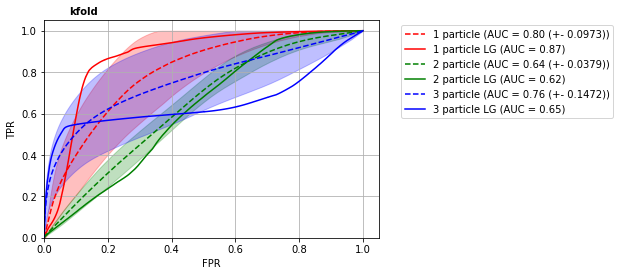

In [26]:
kfoldRoc(f'output/{args.name}.h5', labels, "kfold", "output/", fpr_list, tpr_list, auc_list)

In [37]:
def learningCurves(infile, outdir=""):

    folds = 10
    losses = [[0]*(folds) for i in range(2)]

    with h5.File(infile, 'r') as hfile:
        for i in range(folds):
            losses[0][i] = hfile[f'loss_{i+1}'][()]
            losses[1][i] = hfile[f'val_loss_{i+1}'][()]

    for i in range(len(losses)):
        for j in range(folds):
            plt.plot(losses[i][j], label= ('val_' if i else '') + f'loss for {j} fold')

    #plt.plot([0, 1], [0, 1], lw=1, color='navy', linestyle='--')
    #plt.semilogx()
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    plt.xlim([-0.05, 20])
    plt.ylim(0.2,.60)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'loss',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=10)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    plt.savefig(f'{outdir}loss.pdf')
    plt.close()

In [38]:
learningCurves(f'output/{args.name}.h5', "output/")

[2020-07-09 12:30:30,165 DEBUG] Assigning font /b'F1' = 'C:\\Users\\alexc\\Anaconda3\\envs\\EPE_ML_TF2\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'
[2020-07-09 12:30:30,236 DEBUG] Assigning font /b'F2' = 'C:\\Users\\alexc\\Anaconda3\\envs\\EPE_ML_TF2\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans-Bold.ttf'
[2020-07-09 12:30:30,237 DEBUG] Embedding font C:\Users\alexc\Anaconda3\envs\EPE_ML_TF2\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf.
[2020-07-09 12:30:30,238 DEBUG] Writing TrueType font.
[2020-07-09 12:30:30,248 DEBUG] Embedding font C:\Users\alexc\Anaconda3\envs\EPE_ML_TF2\lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans.ttf.
[2020-07-09 12:30:30,248 DEBUG] Writing TrueType font.


In [21]:
print('---Average scores---')
print('Score per fold')
for i in range(0,len(acc_per_fold)):
    print(f'Fold {i+1} - Loss: {loss_per_fold[i]:.4f} - Accuracy: {acc_per_fold[i]:.2f}%')
print('--------------------')
print('Average scores for all folds:')
print(f'Accuracy: {np.mean(acc_per_fold):.2f} (+- {np.std(acc_per_fold):.4f})')
print(f'Loss: {np.mean(loss_per_fold):.4f} (+- {np.std(loss_per_fold):.4f})')
print('---Average AUC------')
for label in labels:
    for i in range(fold_no-1):
        print(f'Fold {i+1} - {label} - AUC: {auc1[label][i]*100:.2f}')
        
print('--------------------')
print('Average AUC for all folds:')
for label in labels:
    print(f'{label} - AUC: {np.mean(auc1[label]):.2f} (+- {np.std(auc1[label]):.4f})')

---Average scores---
Score per fold
Fold 1 - Loss: 0.0009 - Accuracy: 100.00%
Fold 2 - Loss: 0.0009 - Accuracy: 100.00%
Fold 3 - Loss: 0.0009 - Accuracy: 100.00%
Fold 4 - Loss: 0.0009 - Accuracy: 100.00%
Fold 5 - Loss: 0.0009 - Accuracy: 100.00%
Fold 6 - Loss: 0.0008 - Accuracy: 100.00%
Fold 7 - Loss: 0.0008 - Accuracy: 100.00%
Fold 8 - Loss: 0.0008 - Accuracy: 100.00%
Fold 9 - Loss: 0.0009 - Accuracy: 100.00%
Fold 10 - Loss: 0.0009 - Accuracy: 100.00%
--------------------
Average scores for all folds:
Accuracy: 100.00 (+- 0.0000)
Loss: 0.0009 (+- 0.0000)
---Average AUC------
Fold 1 - 1particle - AUC: nan
Fold 2 - 1particle - AUC: nan
Fold 3 - 1particle - AUC: nan
Fold 4 - 1particle - AUC: nan
Fold 5 - 1particle - AUC: nan
Fold 6 - 1particle - AUC: nan
Fold 7 - 1particle - AUC: nan
Fold 8 - 1particle - AUC: nan
Fold 1 - 2particle - AUC: nan
Fold 2 - 2particle - AUC: nan
Fold 3 - 2particle - AUC: nan
Fold 4 - 2particle - AUC: nan
Fold 5 - 2particle - AUC: nan
Fold 6 - 2particle - AUC: n